In [3]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import CCores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from utils import u_darrays as uda

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
from utils import u_grid, u_interpolate as u_int
import glob

met_folder = '/home/ck/DIR/cornkle/MCSfiles/MSG_cores/coresPower_MSG_-40_9-130km_-50points_dominant_2010_08.nc'

files = glob.glob(met_folder)

ds = xr.open_dataset(files[0])

In [5]:
ds

<xarray.Dataset>
Dimensions:      (lat: 605, lon: 1744, time: 4)
Coordinates:
  * time         (time) datetime64[ns] 2010-08-06T15:00:00 ... 2010-08-13T18:...
  * lat          (lat) float64 4.0 4.027 4.054 4.081 ... 19.89 19.92 19.94 19.97
  * lon          (lon) float64 -18.0 -17.97 -17.95 -17.92 ... 28.92 28.95 28.97
Data variables:
    small_scale  (time, lat, lon) int16 ...
    tir          (time, lat, lon) int16 ...
    dom          (time, lat, lon) int16 ...

In [6]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


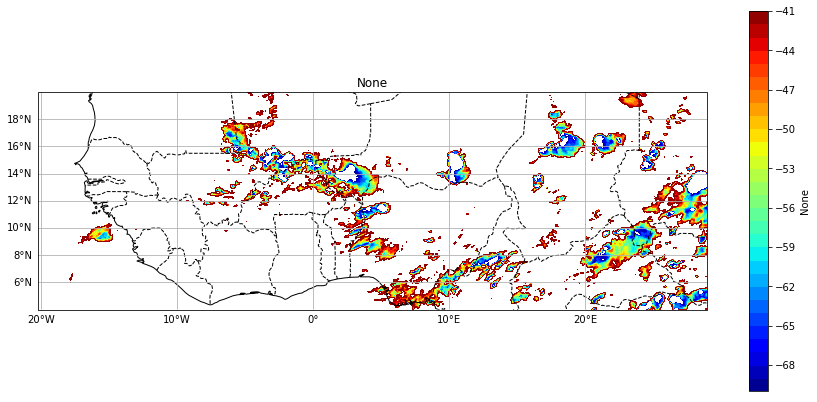

In [11]:
draw_map(ds['tir'].isel(time=0)/100, ds.lon, ds.lat, levels=np.arange(-70,-40), cmap='jet')

In [86]:
files

['/home/ck/DIR/cornkle/MCSfiles/MSG_cores/coresPower_MSG_-40_9-130km_-50points_dominant_2010_08.nc']

In [78]:
centre = ds.isel(time=0)
centre = centre['small_scale'].where(centre['small_scale']<0, drop=True)

In [119]:
vera = xr.open_dataset('/home/ck/DIR/cornkle/MCSfiles/MSG_cores/coresPower_MSG_-40_9-130km_-50points_dominant_2004_06.nc')
verat = vera.isel(time=0)

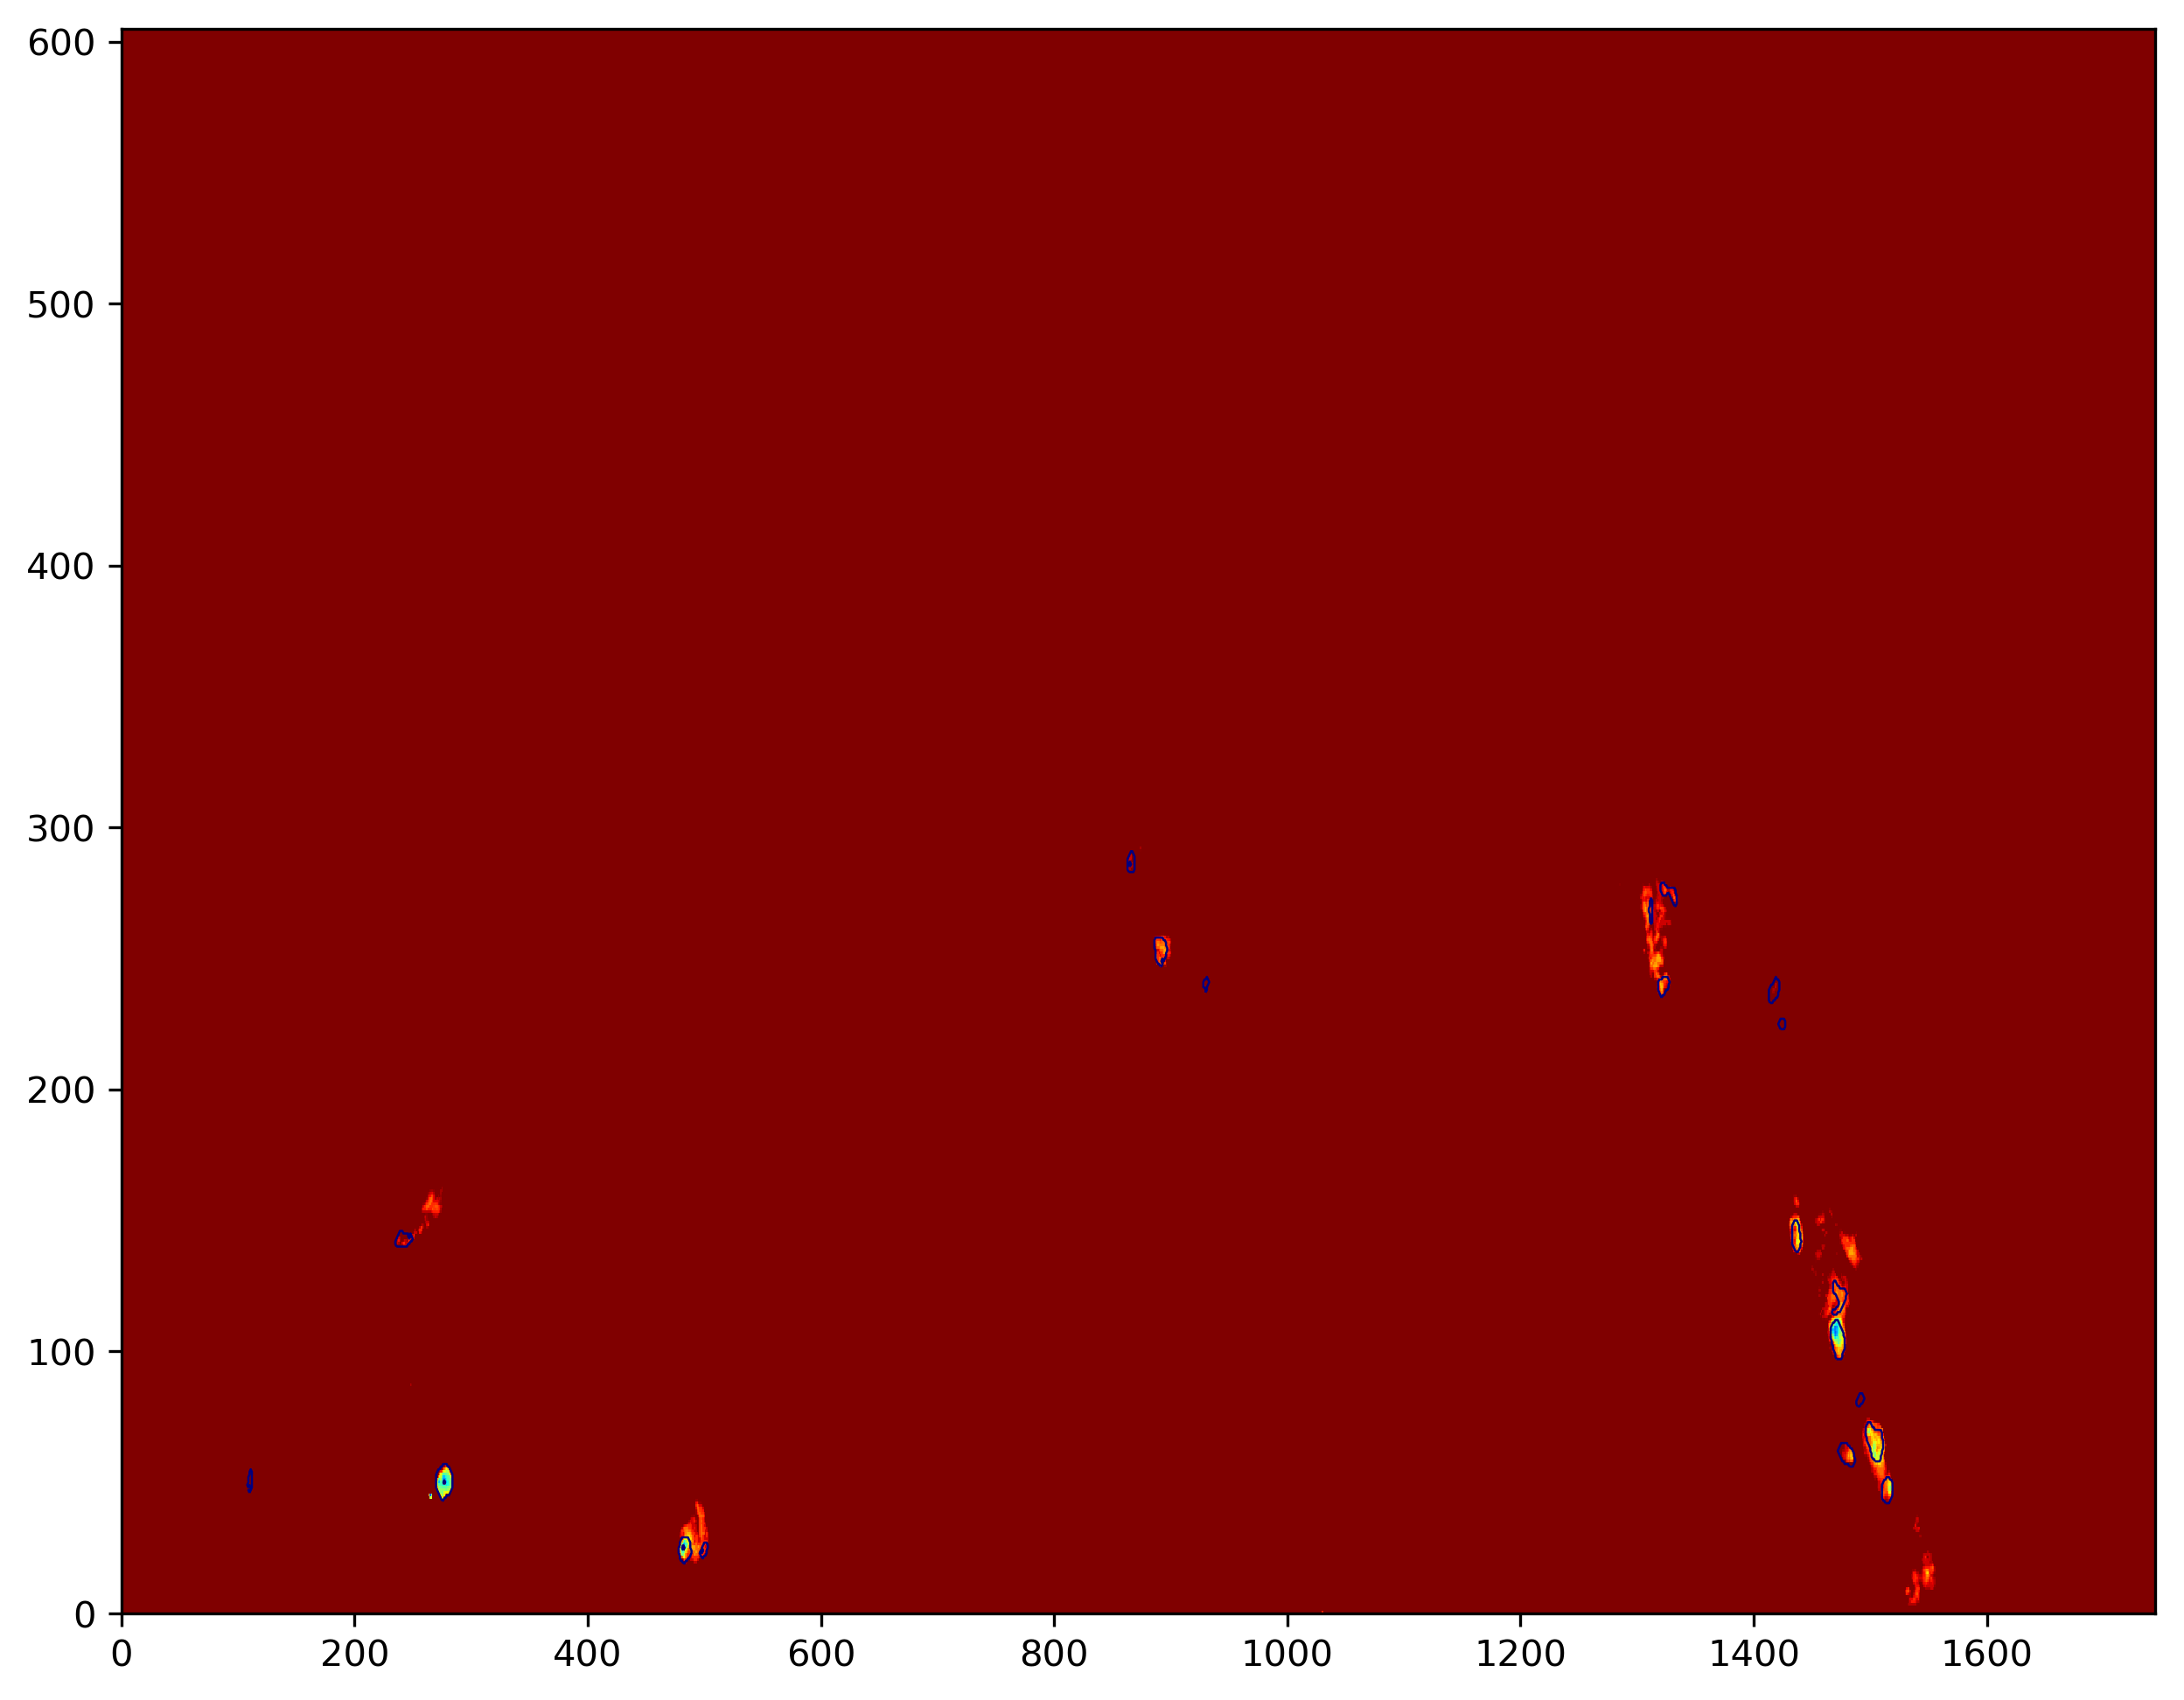

In [126]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(111)

plt.pcolormesh(verat['tir']/100, vmax=-70, vmin=-85, cmap='jet')
plt.contour(verat['small_scale'], levels=[-1,0], cmap='jet_r', linewidths=0.6)


In [50]:
times=0

In [51]:
data_resolution = 3 # in km
# make salem grid
grid3k = ds.salem.grid #u_grid.make(np.arange(-20,30), np.arange(4,20), data_resolution*1000)
dlon = ds['lon'].squeeze().values
dlat = ds['lat'].squeeze().values
x,y = np.meshgrid(dlon,dlat)
inds, weights, shape = u_int.interpolation_weights_grid(x, y, grid3k)

data = ds['tir'].isel(time=times).squeeze().values
try:
    orig3k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon3k, lat3k = grid3k.ll_coordinates

In [52]:
data_resolution = 5 # in km
# make salem grid
grid5k = u_grid.make(np.arange(-20,30), np.arange(4,20), data_resolution*1000)
dlon = ds['lon'].squeeze().values
dlat = ds['lat'].squeeze().values
x,y = np.meshgrid(dlon,dlat)
inds, weights, shape = u_int.interpolation_weights_grid(x, y, grid5k)

data = ds['tir'].isel(time=times).squeeze().values
try:
    orig5k = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lon5k, lat5k = grid5k.ll_coordinates

In [53]:
regrid3k = grid3k.to_dataset()

In [54]:
regrid5k = grid5k.to_dataset()

In [55]:
grid3k

<salem.Grid>
  proj: +datum=WGS84 +no_defs+proj=longlat
  pixel_ref: center
  origin: lower-left
  (nx, ny): (1744, 605)
  (dx, dy): (0.026949458523585434, 0.027063658782299438)
  (x0, y0): (-17.999999999999996, 3.999999999999662)

In [56]:
outt, nogood, t_thresh_size, t_thresh_cut, pix_nb, area_img = powerBlob_utils.filter_img(orig5k/100, 5)
wav = util.waveletT(outt, dataset='METEOSAT5K_vera')
power_msg = powerBlob_utils.find_scales_dominant(wav, nogood, area_img, dataset='MSG')

outmin -89.94102253538688 0.0


In [57]:
old_nflics5k = xr.DataArray(power_msg, coords=[lat5k[:,0], lon5k[0,:]], dims=['lat', 'lon'])

In [58]:
old_nflics5k.name = 'power'

In [59]:
power_msg3k = regrid3k.salem.transform(old_nflics5k)

In [60]:
old_nflics3k = xr.DataArray(power_msg3k, coords=[lat3k[:,0], lon3k[0,:]], dims=['lat', 'lon'])

In [61]:
old_nflics3k.name = 'power'

In [62]:
# wObj2 = cores.dataset('METEOSAT3K_veraLS')
# wObj2.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
# wObj2.applyWavelet()
# v3knflicsv2 = wObj2.scaleWeighting(wtype='nflicsv2')#', data_tag='MSG')

In [63]:
v3knflicsv2 = ds['small_scale'].isel(time=times)

In [64]:
ds['small_scale'].time

<xarray.DataArray 'time' (time: 4)>
array(['2010-08-06T15:00:00.000000000', '2010-08-06T15:30:00.000000000',
       '2010-08-13T15:30:00.000000000', '2010-08-13T18:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-08-06T15:00:00 ... 2010-08-13T18:30:00

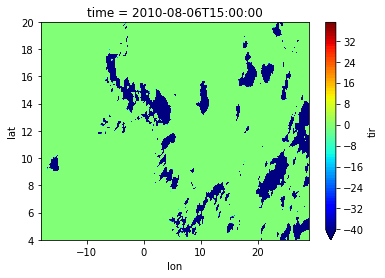

In [65]:
(ds['tir']/100).isel(time=0).plot.contourf(levels=np.arange(-40,40), cmap='jet')

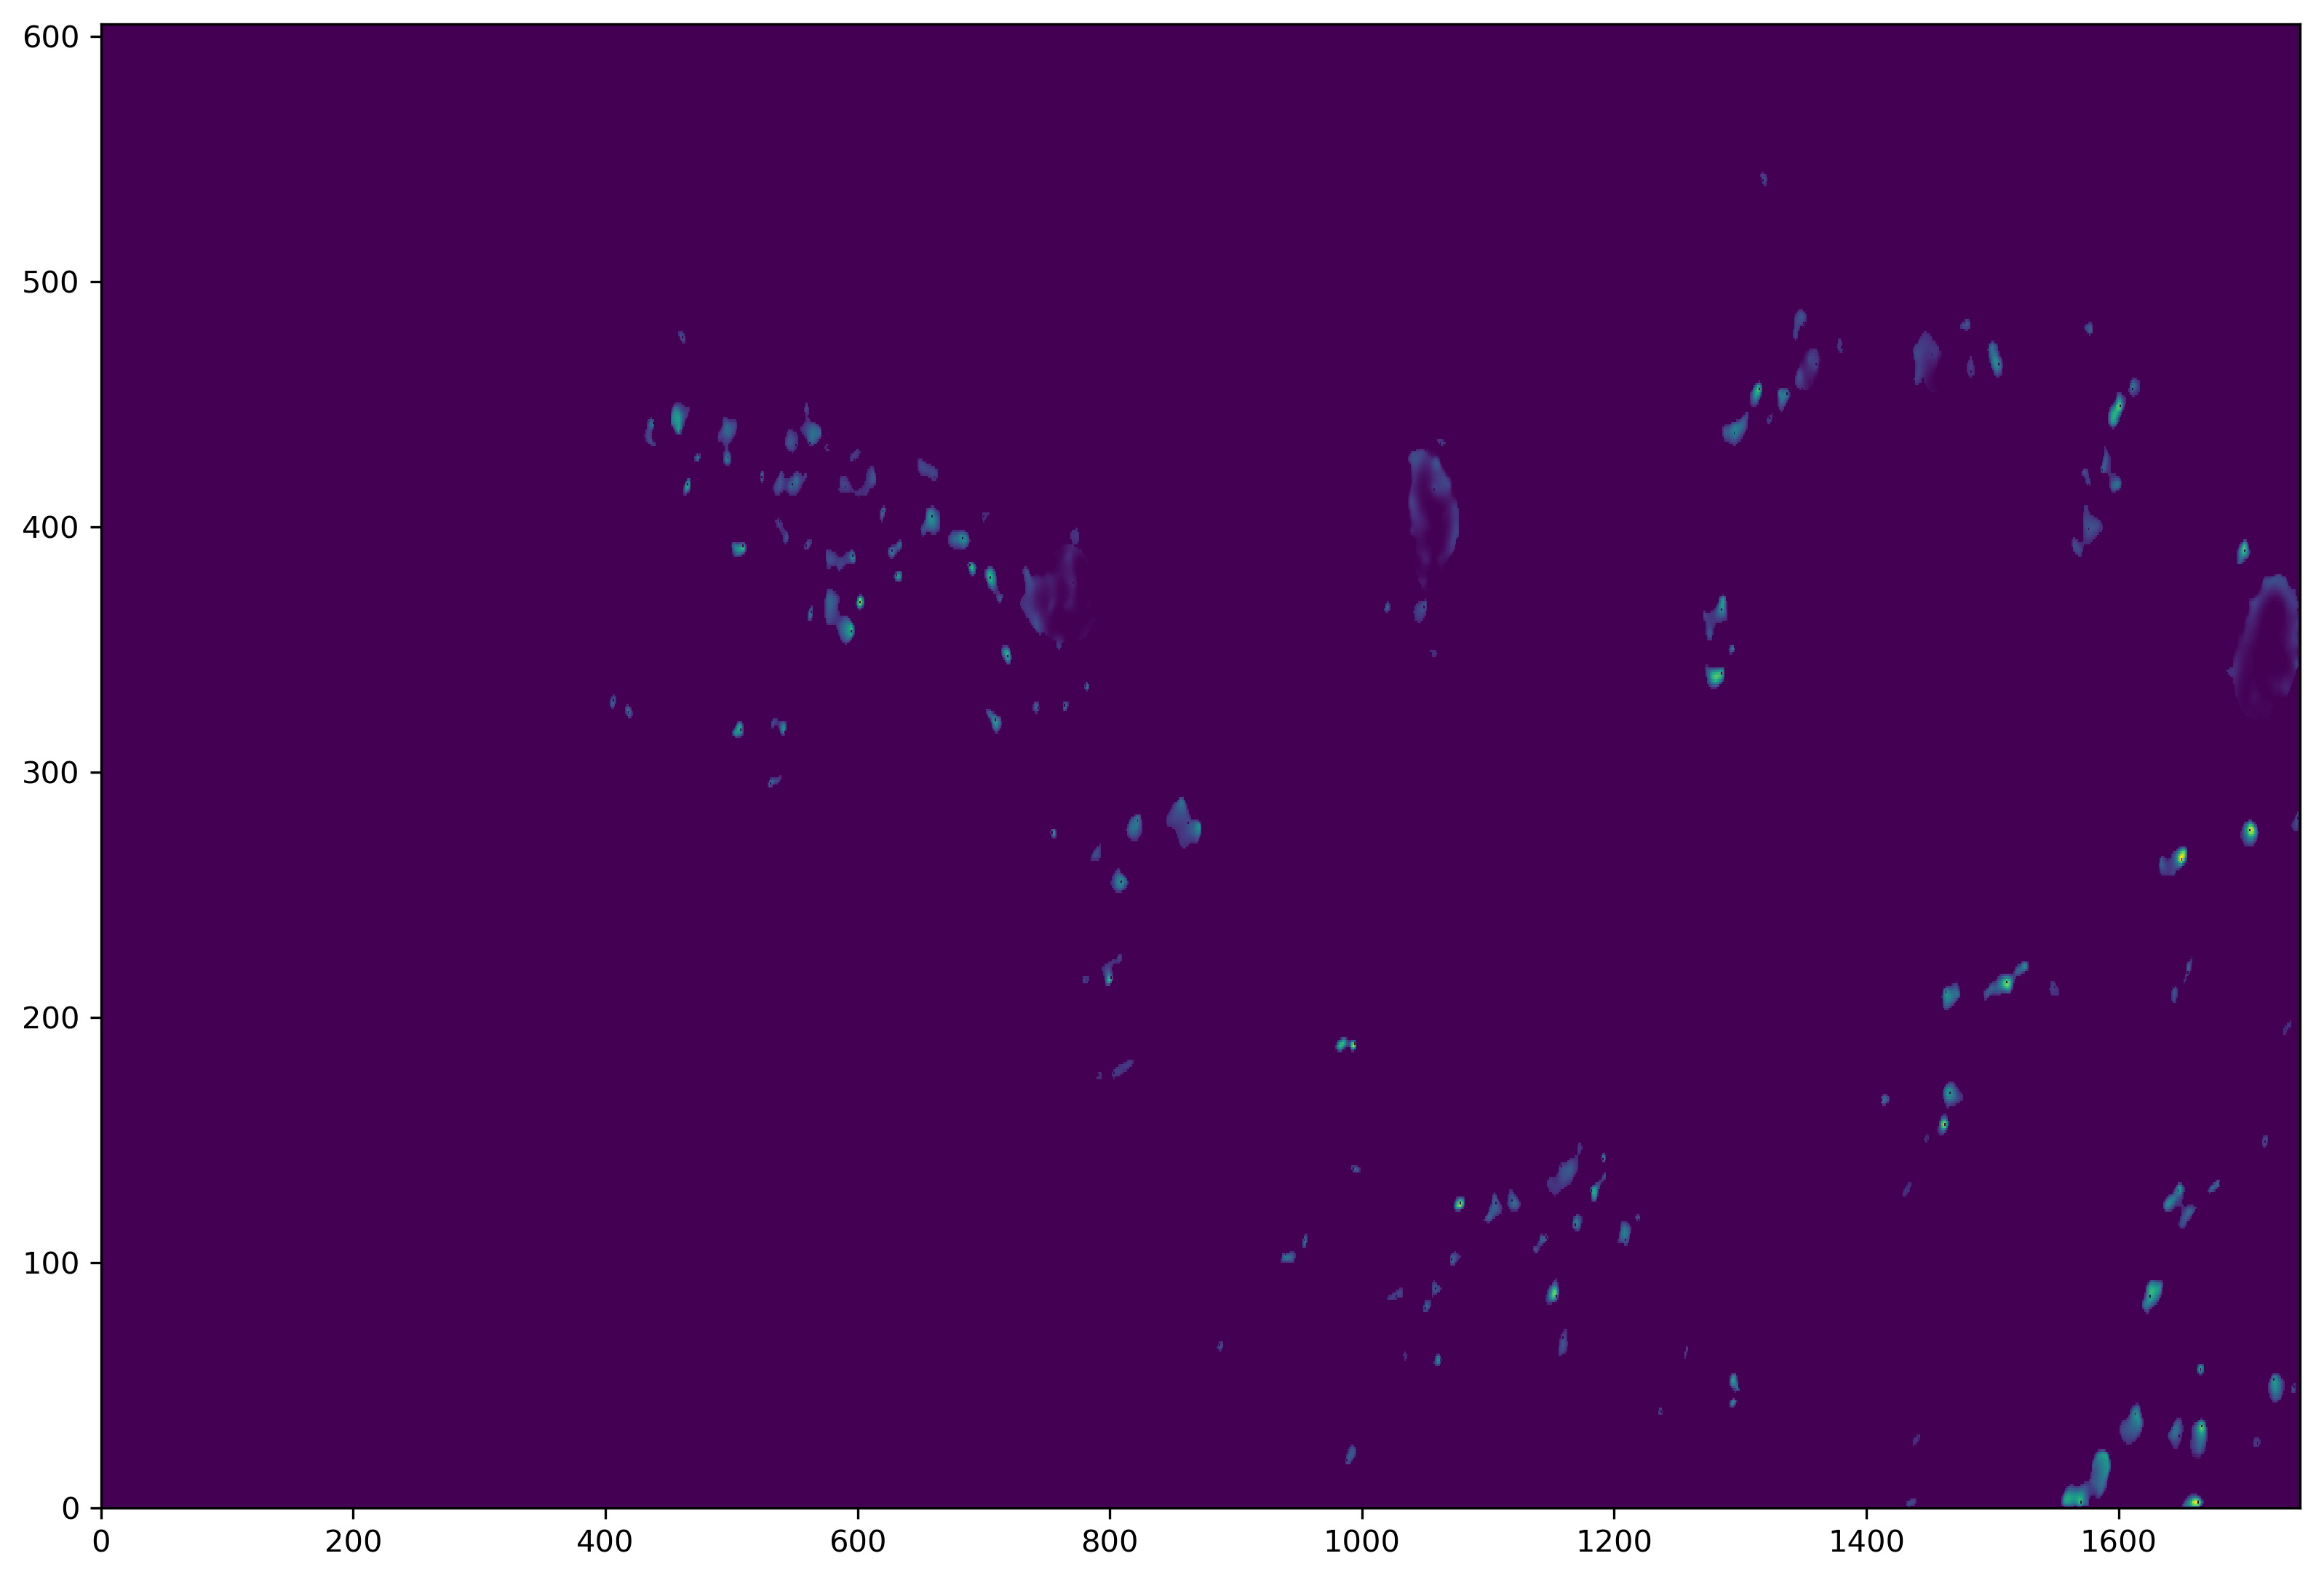

In [66]:
f = plt.figure(figsize=(13,9), dpi=300)
plt.pcolormesh(v3knflicsv2, vmin=1)

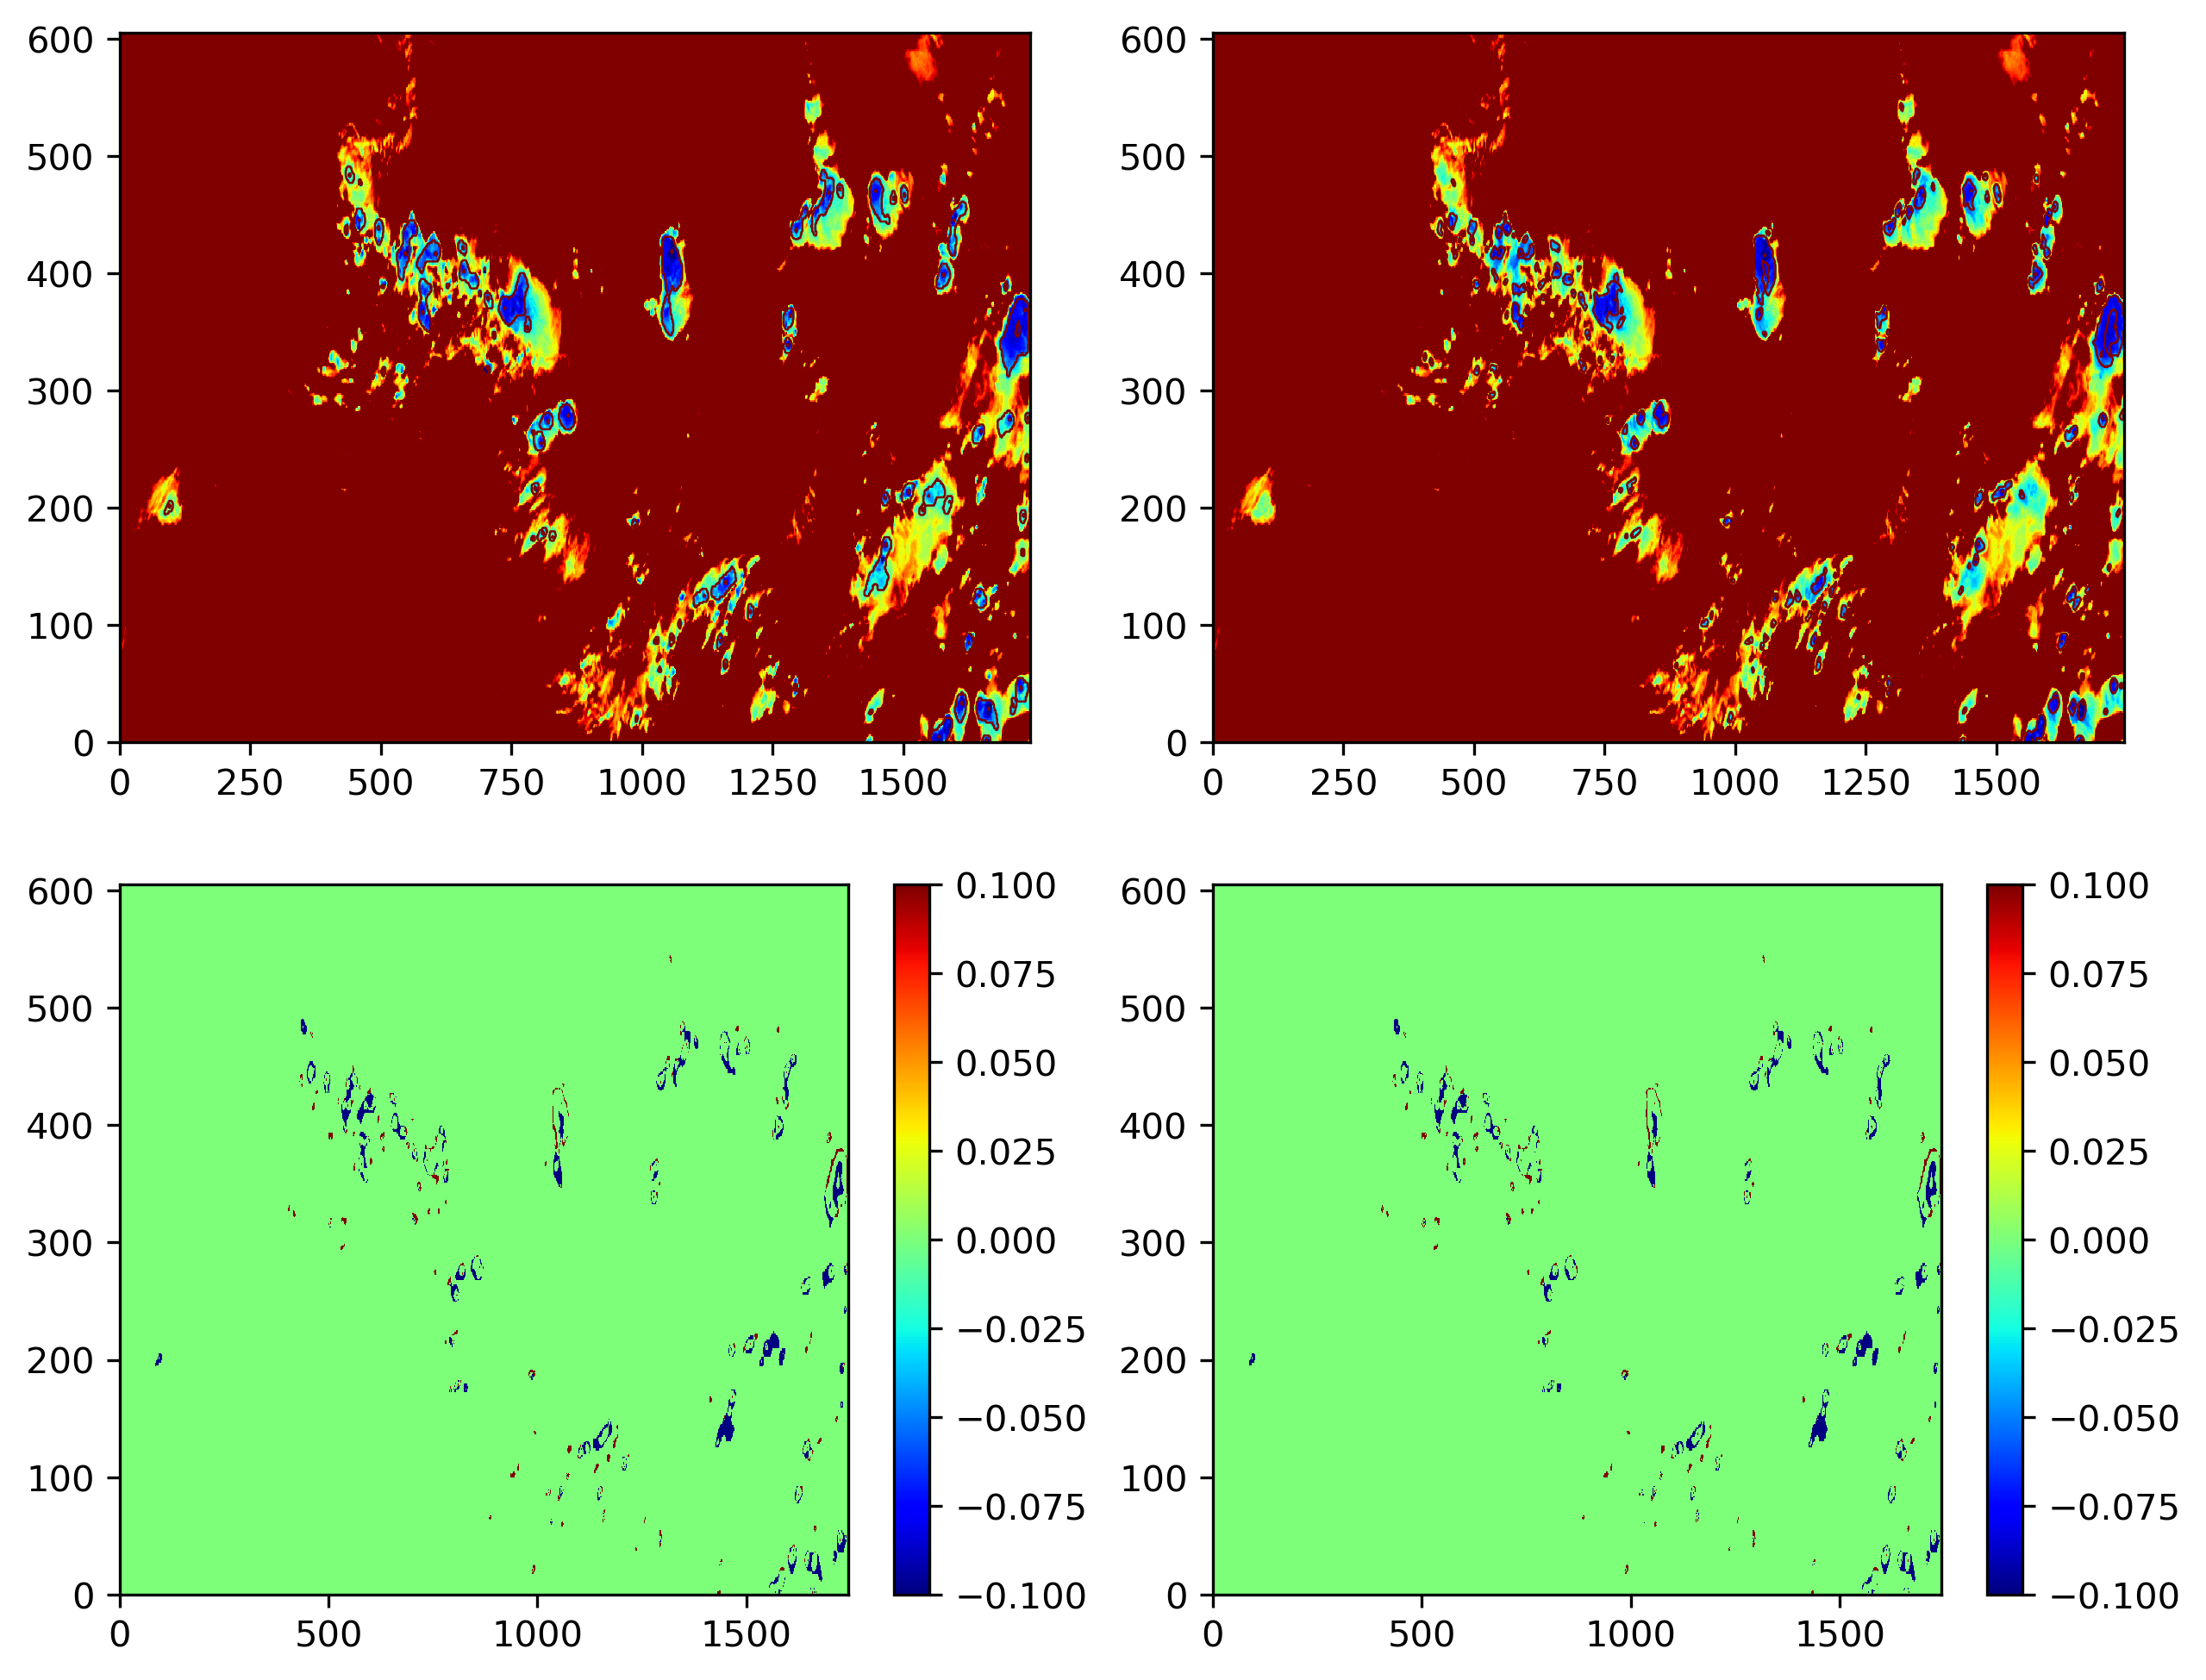

In [118]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(221)

plt.pcolormesh(data/100, vmax=-40, vmin=-85, cmap='jet')
plt.contour(old_nflics3k, levels=[-1,0], cmap='jet', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(data/100, vmax=-40, vmin=-85, cmap='jet')
plt.contour(v3knflicsv2, levels=[-1,0], cmap='jet', linewidths=0.6)

ax = f.add_subplot(223)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

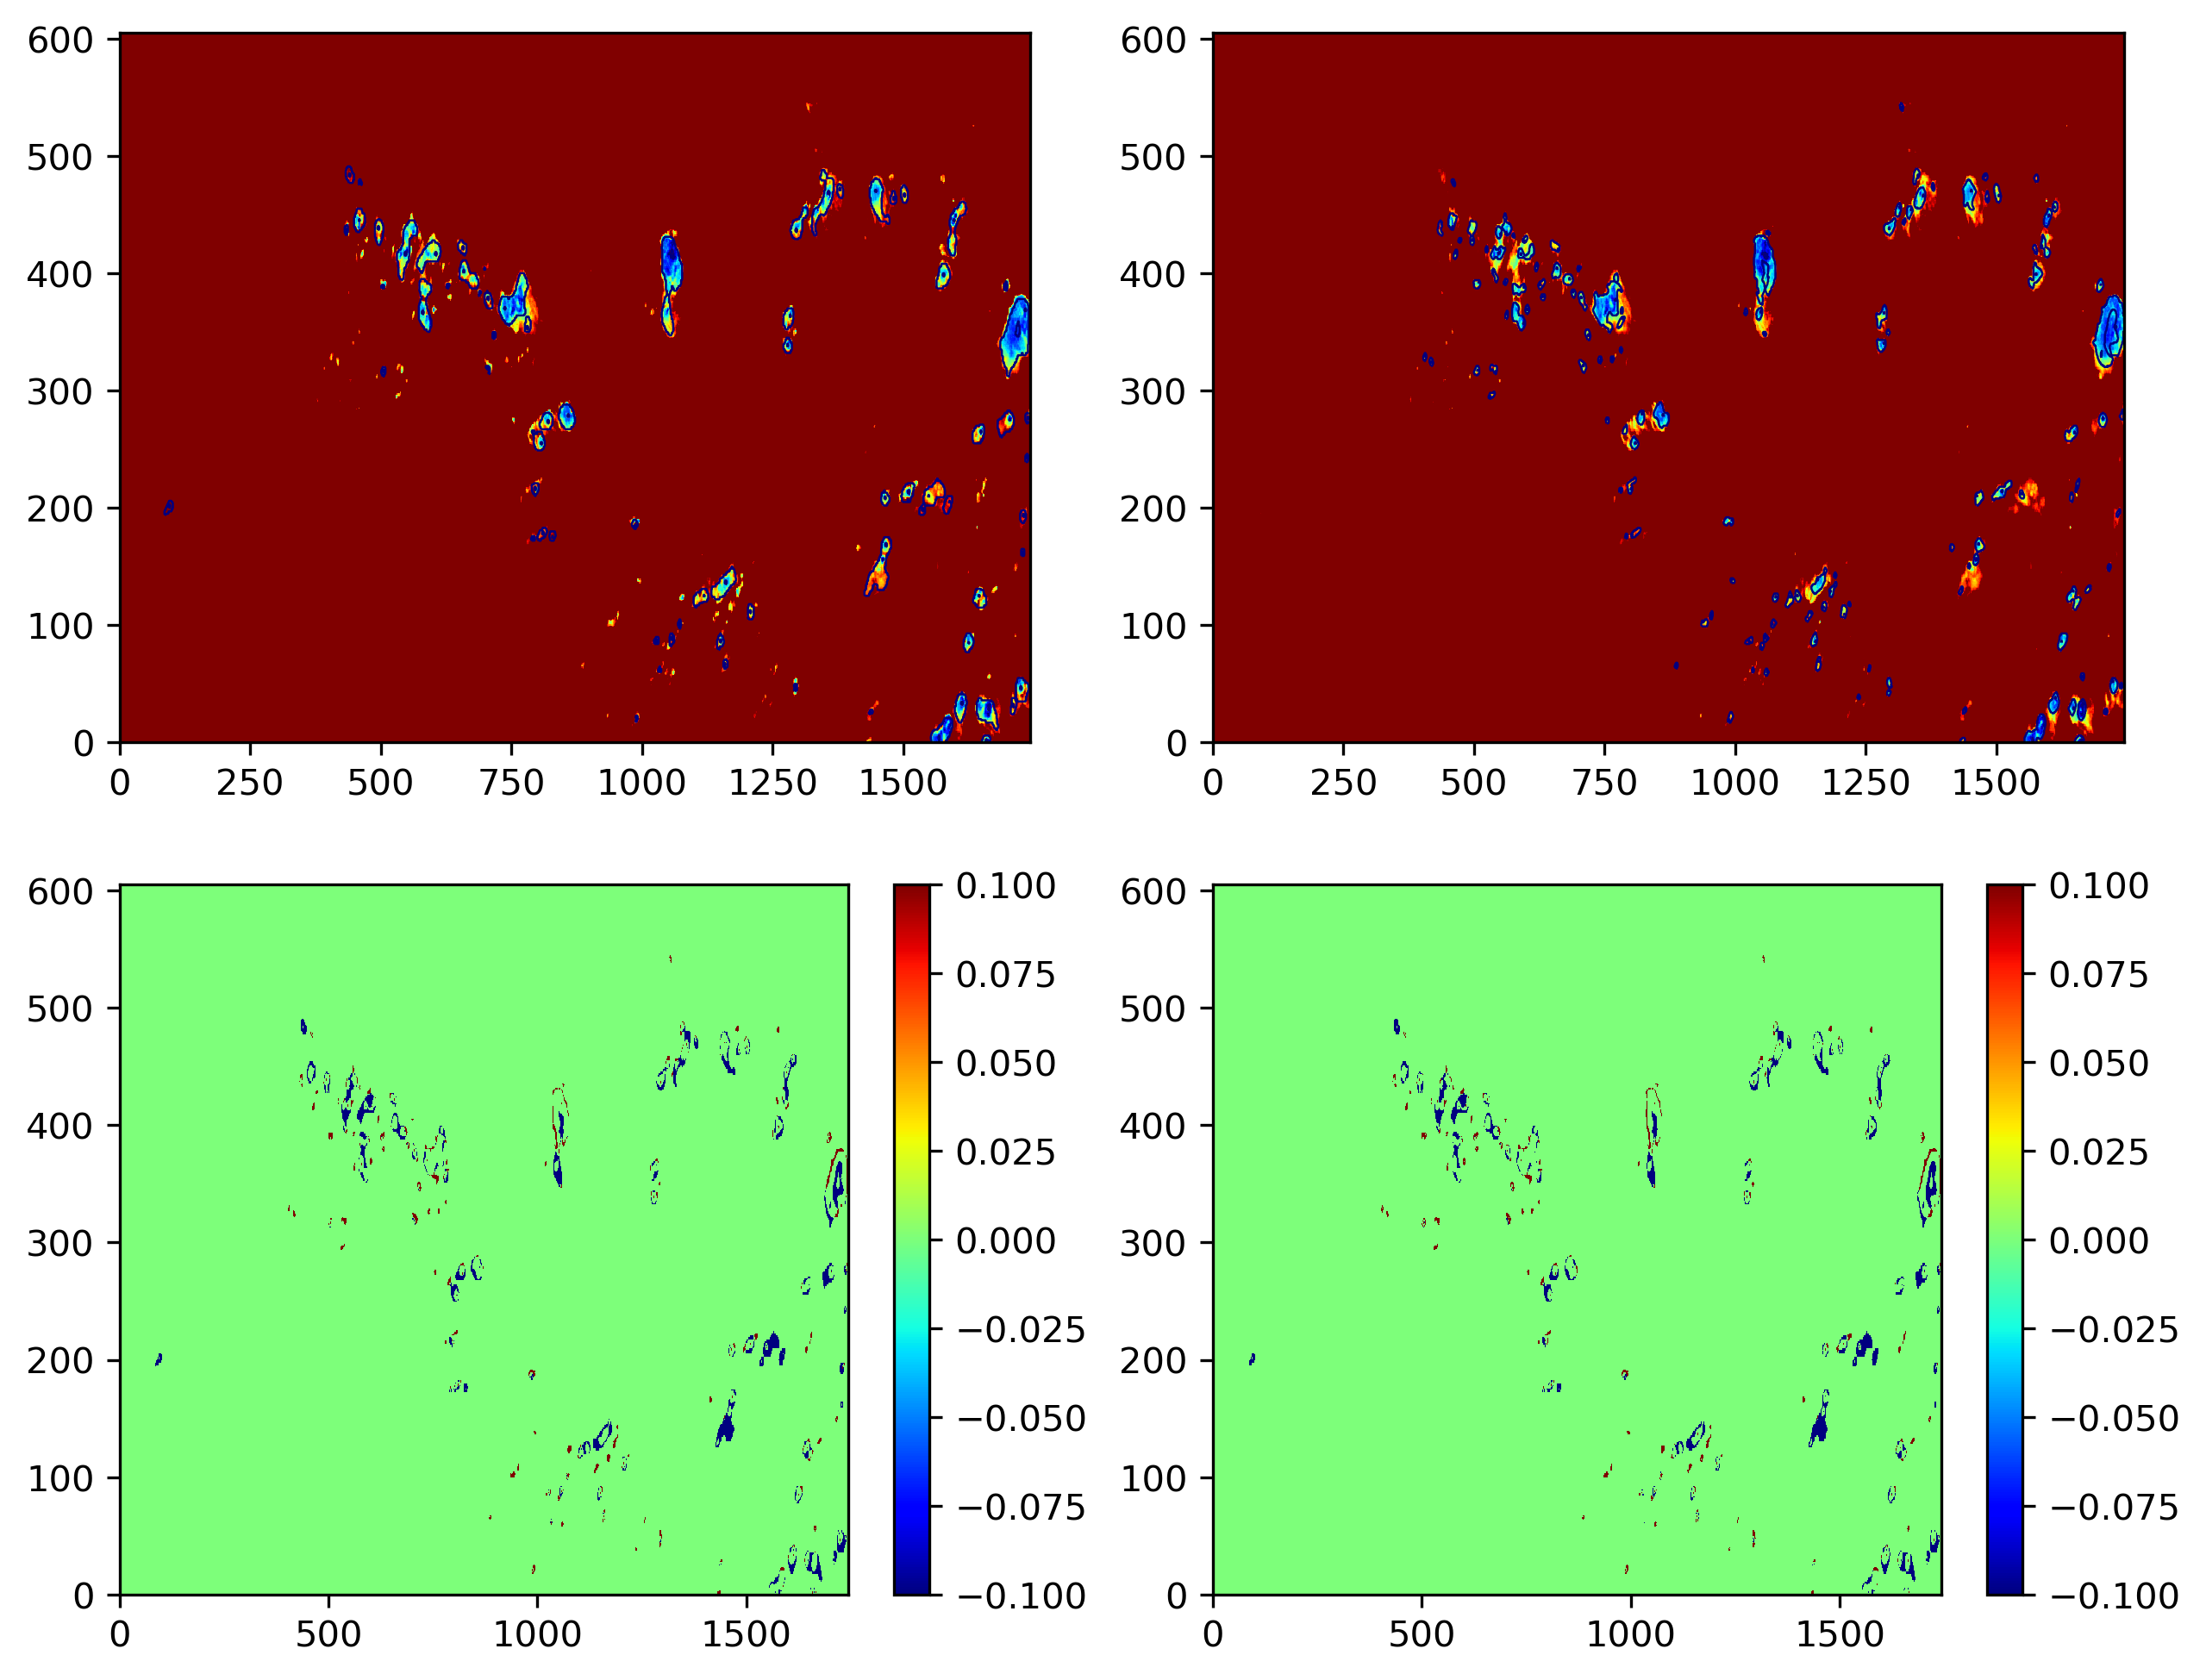

In [68]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(221)

plt.pcolormesh(data/100, vmax=-65, vmin=-85, cmap='jet')
plt.contour(old_nflics3k, levels=[-1,0], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(222)
plt.pcolormesh(data/100, vmax=-65, vmin=-85, cmap='jet')
plt.contour(v3knflicsv2, levels=[-1,0], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(223)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

In [69]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kdominant = wObj3.scaleWeighting(wtype='dominant')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
outmin -9109.405289192666 0.0
9.0
13.0
18.0
24.0
34.0
48.0
66.0
92.0
129.0


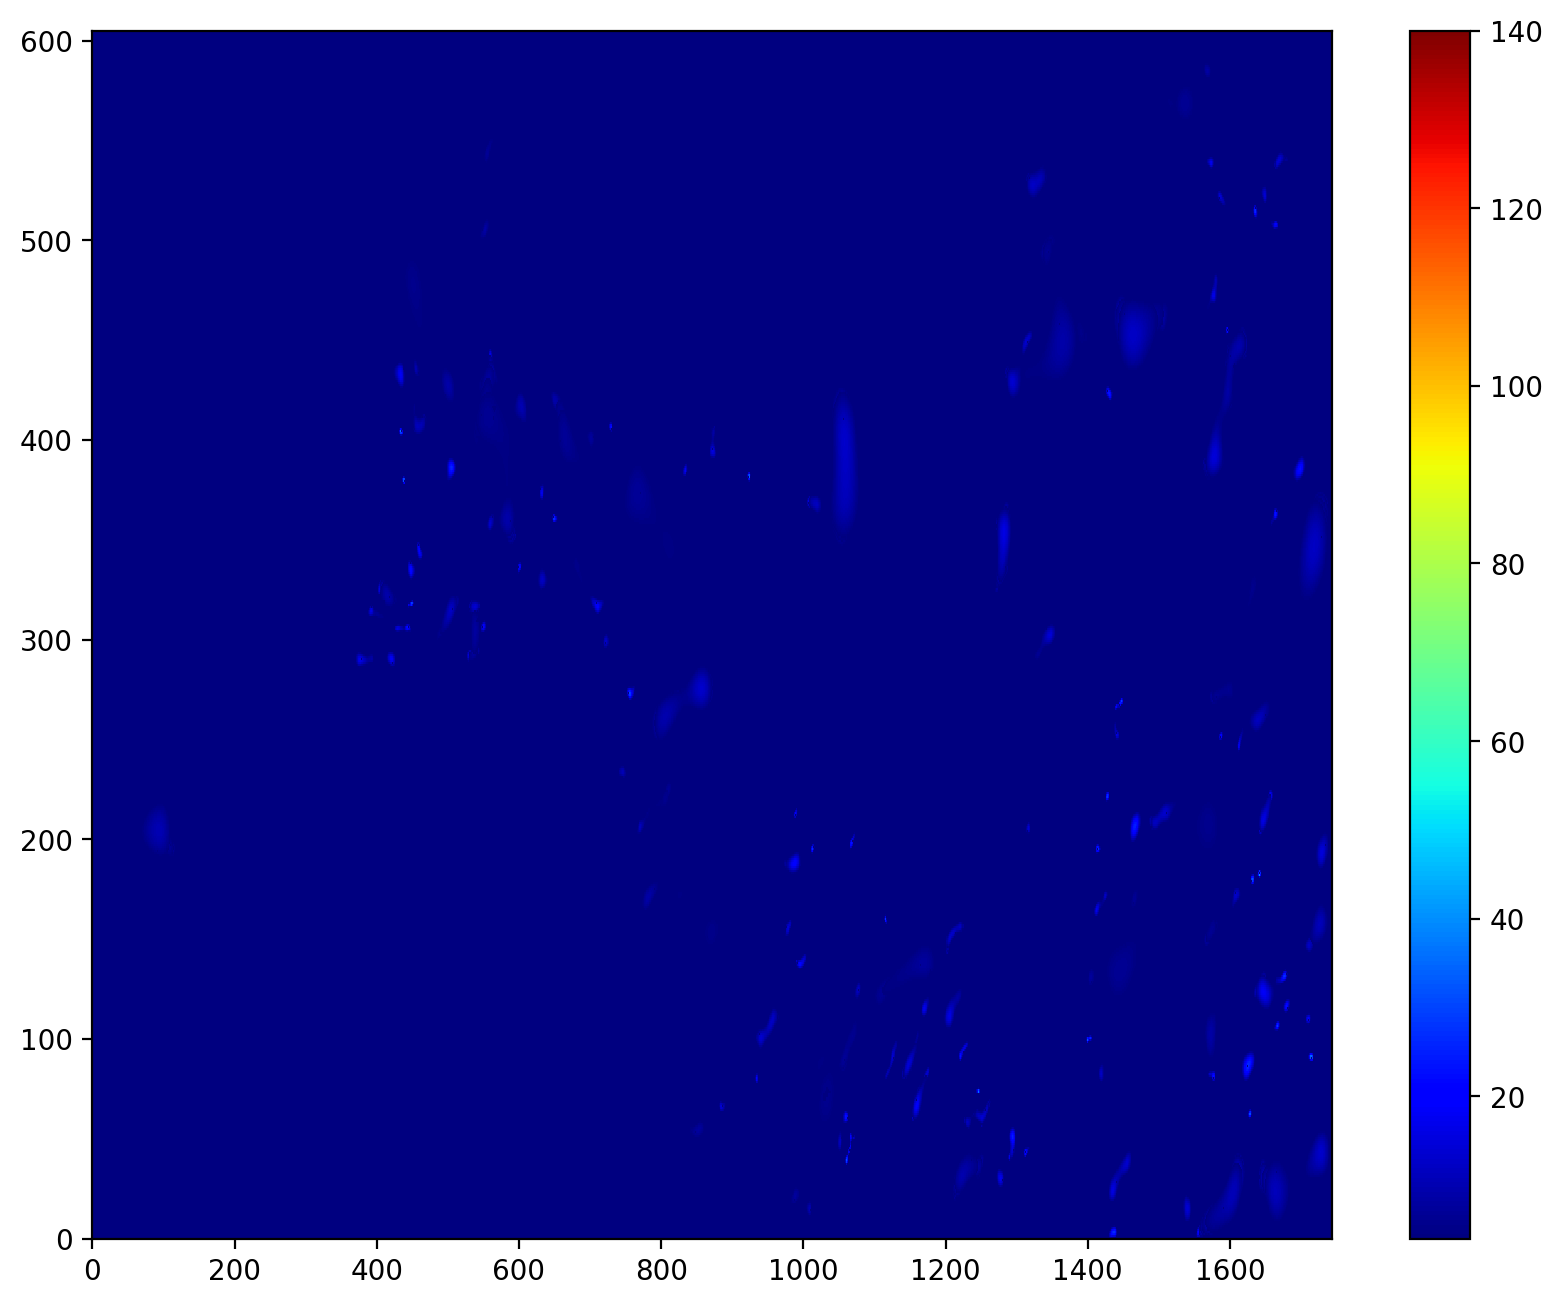

In [70]:
f = plt.figure(figsize=(10,8), dpi=200)


ax = f.add_subplot(111)

plt.pcolormesh(v3kdominant, cmap='jet', vmin=4, vmax=140)
plt.colorbar()

NameError: name 'wObj2' is not defined

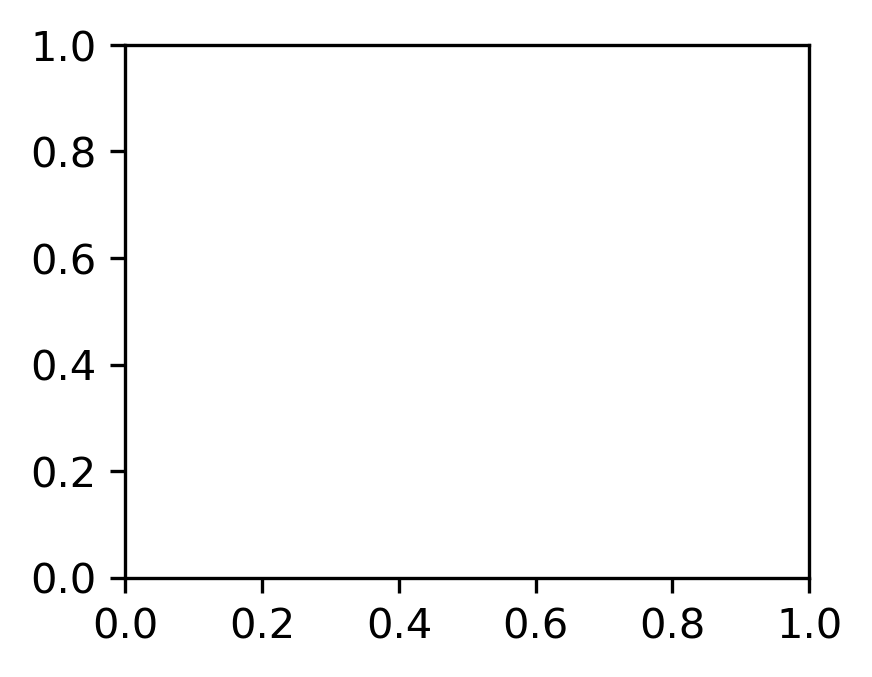

In [71]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(331)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3knflicsv2, levels=[0,1], cmap='jet_r', linewidths=0.6)

ax = f.add_subplot(332)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')

ax = f.add_subplot(333)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(np.sum(v3kindi[0:2,:,:], axis=0), levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)


ax = f.add_subplot(334)
plt.pcolormesh(np.array(v3knflicsv2>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(335)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

ax = f.add_subplot(336)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

In [134]:
wObj3 = cores.dataset('METEOSAT3K_veraLS')
wObj3.read_img(orig3k, lon3k, lat3k, edge_smoothing=False)
wObj3.applyWavelet()
v3kindi = wObj3.scaleWeighting(wtype='ind')#', data_tag='MSG')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
outmin -87.6425906327473 24.2120361328125


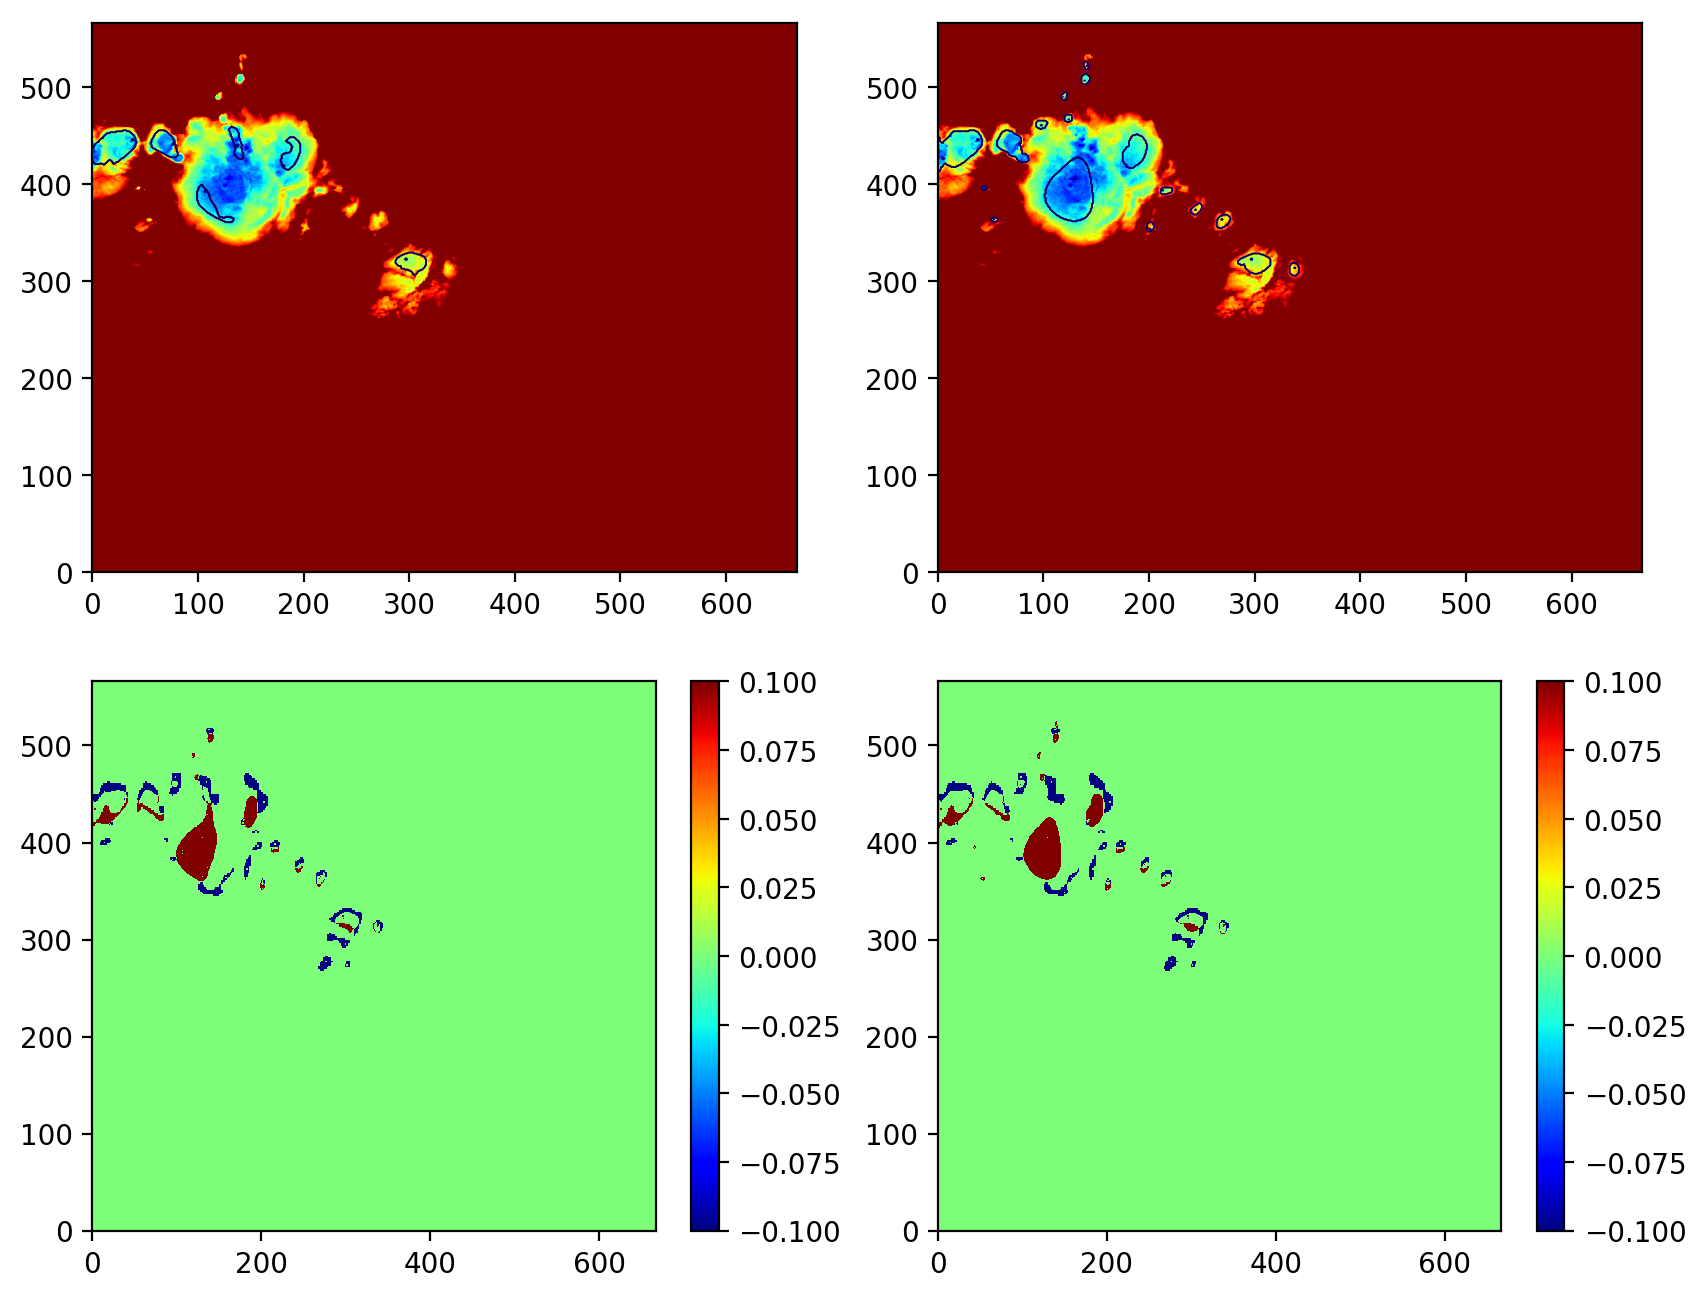

In [125]:
f = plt.figure(figsize=(10,8), dpi=200)
ax = f.add_subplot(221)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')
plt.contour(v3kindi[1,:,:], levels=[0,1], cmap='jet_r', linewidths=0.6) #np.sum(v3kindi, axis=0)

ax = f.add_subplot(222)
plt.contour(v3kdominant, levels=[0,1], cmap='jet_r', linewidths=0.6)
plt.pcolormesh(wObj2.image, vmax=-60, cmap='jet')


ax = f.add_subplot(223)
plt.pcolormesh(np.array(np.sum(v3kindi, axis=0)>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)

plt.colorbar()
ax = f.add_subplot(224)
plt.pcolormesh(np.array(v3kdominant>0).astype(int)-np.array(old_nflics3k>0).astype(int), cmap='jet', vmin=-0.1, vmax=0.1)
plt.colorbar()

(array([1076.,  758.,  439.,  195.,  104.,   63.,   37.,   32.,   28.,
          26.]),
 array([ 1.55512556,  5.27972706,  9.00432856, 12.72893007, 16.45353157,
        20.17813307, 23.90273457, 27.62733607, 31.35193757, 35.07653908,
        38.80114058]),
 <a list of 10 Patch objects>)

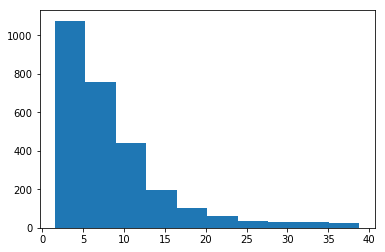

In [126]:
plt.hist(v3kindi[1,:,:][v3kindi[1,:,:]>0.1])